In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# === 1. Load Data ===
df = pd.read_csv("landmark.csv", delimiter=';')

In [249]:
# === 2. Bersihkan Data ===
df.dropna(inplace=True)  # Hapus baris kosong
df = df.applymap(lambda x: str(x).replace(',', '.'))  # Ganti koma ke titik
for col in df.columns:
    if col != 'label':
        df[col] = df[col].astype(float)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7124\268239681.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(',', '.'))  # Ganti koma ke titik


In [250]:
# === 3. Fungsi Hitung Sudut Siku ===
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

In [251]:
# === 4. Hitung Sudut Siku Kanan ===
df['elbow_angle_right'] = df.apply(
    lambda row: calculate_angle(
        [row['right_shoulder_x'], row['right_shoulder_y']],
        [row['right_elbow_x'], row['right_elbow_y']],
        [row['right_wrist_x'], row['right_wrist_y']]
    ), axis=1
)
df['elbow_angle_left'] = df.apply(
    lambda row: calculate_angle(
        [row['left_shoulder_x'], row['left_shoulder_y']],
        [row['left_elbow_x'], row['left_elbow_y']],
        [row['left_wrist_x'], row['left_wrist_y']]
    ), axis=1
)

In [252]:
def label_from_angle(angle):
    if 10 <= angle <= 25:
        return 'benar'
    elif 160 <= angle <= 175:
        return 'benar'
    else:
        return 'salah'

df['label'] = df['elbow_angle_right'].apply(label_from_angle)


In [253]:
# === 6. Filter hanya label yang benar/salah ===
df = df[df['label'].isin(['benar', 'salah'])]

In [254]:
# === 7. Hapus Kolom Tidak Perlu ===
columns_to_drop = [col for col in df.columns if 'nose' in col.lower() or 'hip' in col.lower() or col.lower().endswith('_v') or col.lower().endswith('_z')]
columns_to_drop += ['elbow_angle_right']  # Sudut tidak dipakai dalam fitur
df.drop(columns=columns_to_drop, inplace=True)

In [255]:
# === 8. Ringkasan Statistik ===
print("\n📊 Ringkasan Statistik:")
print(df.describe())


📊 Ringkasan Statistik:
       left_shoulder_x  left_shoulder_y  right_shoulder_x  right_shoulder_y  \
count     15372.000000     15372.000000      15372.000000      15372.000000   
mean          0.525773         0.352126          0.473490          0.351894   
std           0.059491         0.051274          0.054430          0.052372   
min           0.384465         0.218894          0.382001          0.210146   
25%           0.485937         0.319704          0.417872          0.318591   
50%           0.526775         0.354833          0.473818          0.352566   
75%           0.586608         0.387314          0.510937          0.388858   
max           0.647344         0.543683          0.606968          0.559406   

       right_elbow_x  right_elbow_y  left_elbow_x  left_elbow_y  \
count   15372.000000   15372.000000  15372.000000  15372.000000   
mean        0.462984       0.496475      0.536647      0.495050   
std         0.058408       0.050537      0.063684      0.049093

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7124\2712564414.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


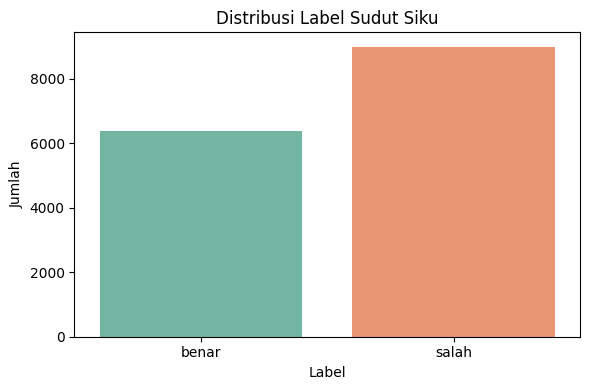

In [256]:
# === 9. Visualisasi Label Baru ===
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', palette='Set2')
plt.title('Distribusi Label Sudut Siku')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

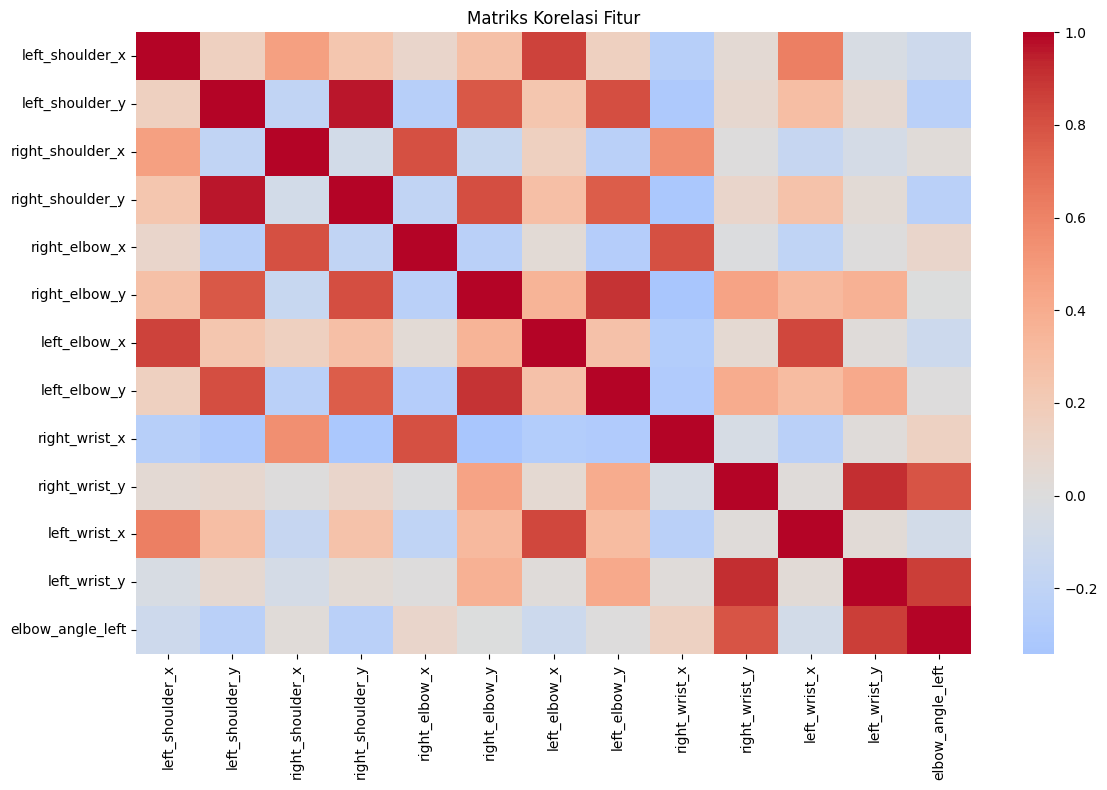

In [257]:
# === 10. Korelasi Fitur ===
plt.figure(figsize=(12, 8))
sns.heatmap(df.drop(columns='label').corr(), cmap='coolwarm', center=0)
plt.title("Matriks Korelasi Fitur")
plt.tight_layout()
plt.show()

In [258]:
# === 11. Split Data & Training ===
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()


📈 Classification Report:
              precision    recall  f1-score   support

       benar       0.80      0.84      0.82      1288
       salah       0.88      0.85      0.86      1787

    accuracy                           0.85      3075
   macro avg       0.84      0.85      0.84      3075
weighted avg       0.85      0.85      0.85      3075



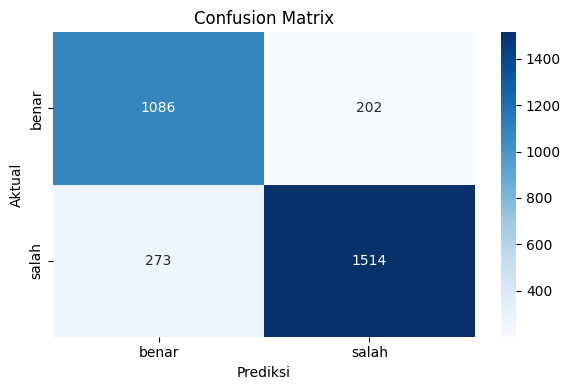

In [259]:
# === 12. Evaluasi Model ===
y_pred = knn.predict(X_test)
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['benar', 'salah'], yticklabels=['benar', 'salah'])
plt.title("Confusion Matrix")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.tight_layout()
plt.show()

In [260]:
# === 13. Simpan Model ===
joblib.dump(knn, "model_knn_bicep.pkl")
df.to_csv("landmark_cleaned.csv", index=False)
print("✅ Model disimpan ke 'model_knn_bicep.pkl'")

✅ Model disimpan ke 'model_knn_bicep.pkl'
